#### Programa de Formación en ML & DS
## Introducción al Aprendizaje Automático 
# Sesión 10: Clustering

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from IPython.display import HTML

%matplotlib inline

!wget https://gist.githubusercontent.com/fagonzalezo/d4c3992ba89f7598a75adc5290531451/raw/de2edd17e526a96ff9e063c9014f7e0c4a06e922/cluster1.csv
from sklearn.metrics import silhouette_score

def experiment_number_of_clusters(X, clustering, show_metric=True,
                                  plot_data=True, plot_centers=True, plot_boundaries=False):
    plt.figure(figsize=(15,6))
    for n_clusters in range(2,10):
        clustering.n_clusters = n_clusters
        y = clustering.fit_predict(X)

        cm = plt.cm.plasma
        plt.subplot(2,4,n_clusters-1)

        plot_cluster_predictions(clustering, X, n_clusters, cm, 
                                 plot_data, plot_centers, show_metric)
        
def plot_cluster_predictions(clustering, X, n_clusters = None, cmap = plt.cm.plasma,
                             plot_data=True, plot_centers=True, show_metric=False,
                             title_str=""):

    assert not hasattr(clustering, "n_clusters") or \
           (hasattr(clustering, "n_clusters") and n_clusters is not None), "must specify `n_clusters` for "+str(clustering)

    if n_clusters is not None:
        clustering.n_clusters = n_clusters

    y = clustering.fit_predict(X)
    # remove elements tagged as noise (cluster nb<0)
    X = X[y>=0]
    y = y[y>=0]

    if n_clusters is None:
        n_clusters = len(np.unique(y))

    if plot_data:        
        plt.scatter(X[:,0], X[:,1], color=cmap((y*255./(n_clusters-1)).astype(int)), alpha=.5)
    if plot_centers and hasattr(clustering, "cluster_centers_"):
        plt.scatter(clustering.cluster_centers_[:,0], clustering.cluster_centers_[:,1], s=150,  lw=3,
                    facecolor=cmap((np.arange(n_clusters)*255./(n_clusters-1)).astype(int)),
                    edgecolor="black")   

    if show_metric:
        if hasattr(clustering, 'inertia_'):
          inertia = clustering.inertia_
        else:
          inertia = 0
        sc = silhouette_score(X, y) if len(np.unique(y))>1 else 0
        plt.title("k=%d, inertia=%.0f sc=%.3f"%(n_clusters, inertia, sc)+title_str)
    else:
        plt.title("k=%d"%n_clusters+title_str)

    plt.axis("off")
    return

--2019-06-11 23:31:03--  https://gist.githubusercontent.com/fagonzalezo/d4c3992ba89f7598a75adc5290531451/raw/de2edd17e526a96ff9e063c9014f7e0c4a06e922/cluster1.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18736 (18K) [text/plain]
Saving to: ‘cluster1.csv.1’

cluster1.csv.1      100%[===================>]  18.30K  --.-KB/s    in 0.004s  

2019-06-11 23:31:03 (4.88 MB/s) - ‘cluster1.csv.1’ saved [18736/18736]



**Qué es clustering?**

- **Objetivo**: agrupar objetos físicos o abstractos en clases de objetos **similares**
- Es una tarea **NO SUPERVISADA** $\rightarrow$ no sabemos a priorí cómo clasificar nuestros objetos
- Es una tarea **NO COMPLETAMENTE DEFINIDA** $\rightarrow$ ¿Cómo cuantificamos el desempeño de un resultado de clustering?


- ¿Qué definición de **similitud** establecemos?

**Ejemplos de aplicaciones de clustering**

- Taxonomías en biología, agrupaciones por similitud biológica, o incluso genética (big data!!)
- Páginas similares para estructurar resultados de búsquedas (p.ej. La búsqueda de "película" podría devolver resultados agrupados por descripciones similares.
- Segmentación de clientes o usuarios por un criterio de similitud definido.


## Intuición

¿Qué grupos indentifica en los siguientes datos?,  ¿Cómo se puede automatizar el proceso?

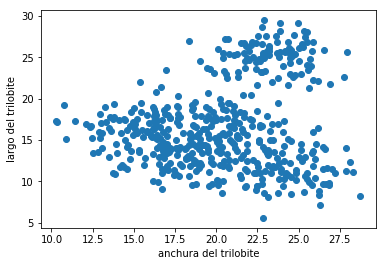

In [4]:

X = pd.read_csv("cluster1.csv").values+15
plt.scatter(X[:,0], X[:,1])
plt.xlabel("anchura del trilobite")
plt.ylabel("largo del trilobite");

## Métodos basados en centroides -  KMeans

El algoritmo k-means (o k-medias), es un método de agrupamiento que asume que los grupos (clusters) están representadas por un prototipo que corresponde al centroide del conjunto de datos. Es un algoritmo iterativo que en cada iteración asigna los elementos al centroide más cercano y recalcula los centroides de acuerdo con los nuevos elementos asignados. 

In [0]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/BVFG7fd1H30" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')


Pseudo código

    Entrada: 
        X: datos
        k: número de clusters deseados
        
    Algoritmo:
        1. selecciona k centroides aleatoriamente
        2. repite hasta que los k centroides no cambien:
        3.     establece k clusters asignado cada dato al centroide más cercano
        4.     recalcula el centroide de cada cluster como el promedio de los datos

El siguiente código aplica el algoritm k-means a un conjunto de datos. Puesto que es un modelo no supervisado, la función `fit` solo recibe como argumento los datos de entrada, no las etiquetas. La función `predict` asigna clusters a los ejemplos, tanto a los de entrenamiento como a ejemplos nuevos.

In [0]:
X = pd.read_csv("cluster1.csv").values+15
n_clusters = 2

km = KMeans( n_clusters=n_clusters)
km.fit(X)
y = km.predict(X)
X.shape


# se puede hacer y=km.fit_predict(X)

(500, 2)

Usamos `pandas` para contar el número de elementos en cada cluster:

In [0]:
pd.Series(y).value_counts()

0    392
1    108
dtype: int64

Las coordenadas de los centroides se pueden obtener con `cluster_centers`:

In [0]:
km.cluster_centers_

array([[19.5061742 , 14.31526768],
       [23.01615594, 24.85357474]])

El siguiente código dibuja los datos agrupados junto con los centroides:

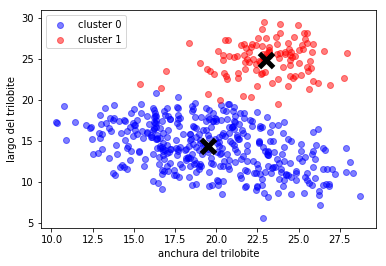

In [0]:

cmap = plt.cm.plasma

cmap((y*255./(n_clusters-1)).astype(int))
for i in np.unique(y):
    cmap = plt.cm.bwr
    col = cmap((i*255./(n_clusters-1)).astype(int))
    Xr = X[y==i]
    plt.scatter(Xr[:,0], Xr[:,1], color=col, label="cluster %d"%i, alpha=.5)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1],marker="x", lw=5, s=200, color="black")
plt.legend()    
plt.xlabel("anchura del trilobite")
plt.ylabel("largo del trilobite");

In [0]:
km.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 2,
 'n_init': 10,
 'n_jobs': None,
 'precompute_distances': 'auto',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

La función `experiment_number_of_clusters` (definida al principio del notebook) muestra resultados con diferente número de clusters:

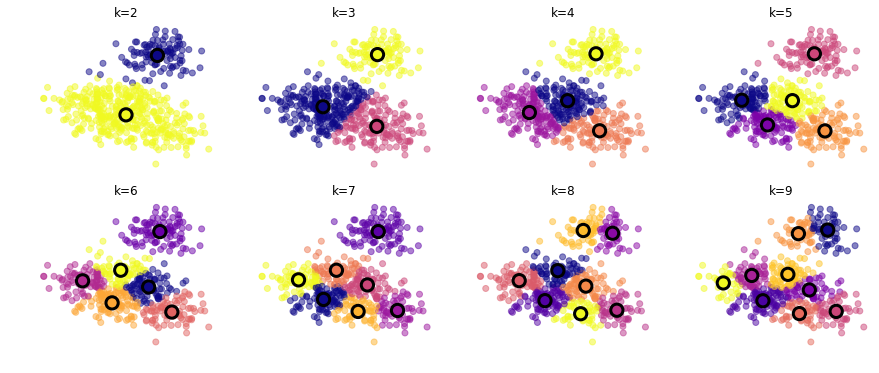

In [5]:
X = pd.read_csv("cluster1.csv").values

experiment_number_of_clusters(X, KMeans(), show_metric=False)

### Experimenta con distintos datasets sintéticos

- Cambia `cluster_std` y `centers` en `make_blobs` para generar datasets con distintas distribuciones
- ¿Cuál es el número de clusters _natural_ que usarías? ¿por qué es _natural_?

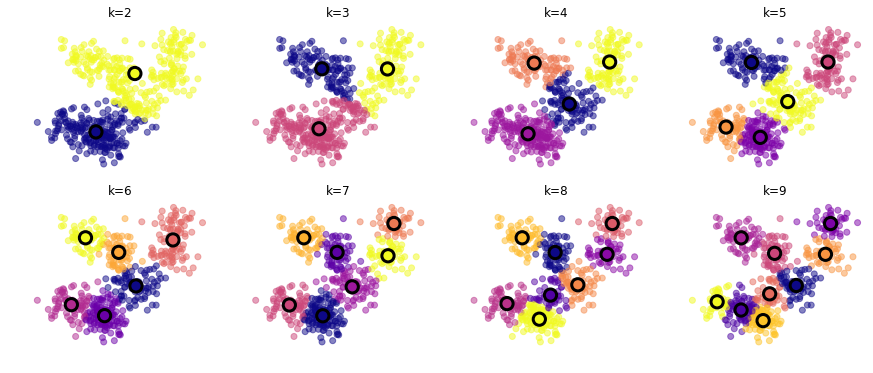

In [0]:
X,_ = make_blobs(500, cluster_std=1.5, centers=10)
experiment_number_of_clusters(X, KMeans(), show_metric=False)

## Cómo seleccionar el número de clusters? 

Para esto necesitamos usar una medida objetiva de la calidad de un clustering. Estas medidas se encuentran definidas en el paquete [`sklearn.metrics.cluster`](http://scikit-learn.org/stable/modules/classes.html#clustering-metrics). Algunas medidas son supervisadas y otras no-supervisadas:
*  **Medidas supervisadas**: utilizan las etiquetas reales de los ejemplos para analizar la correspondencia entre clusters y clases.
* **Medidas no-supervisadas**: calculan medidas basadas en las distancias intra-cluster y/o inter-cluster.

### Inercia o distancia intra-cluster

La distancia intra-cluster mide qué tan compacto es cada cluster y se define como:

$$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$$

k-means minimiza esta medida, lo cual la hace una buena candidata para evaluar la calidad de un cluster. Para esto ejecutamos k-means con diferentes valores de k y graficamos el valor de la inercia. En esta gráfica buscamos un valor de k tan pequeño como sea posible y que tenga un valor de la métrica bajo. A este tipo de gráfica se le conoce usualmente como gráfica de codo:

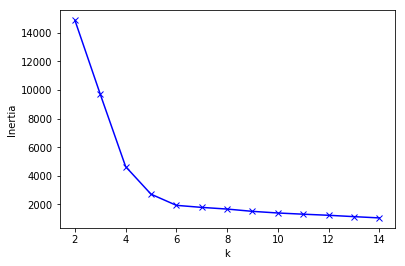

In [0]:
X,_ = make_blobs(500, cluster_std=1.5, centers=6, random_state=10)

Sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()


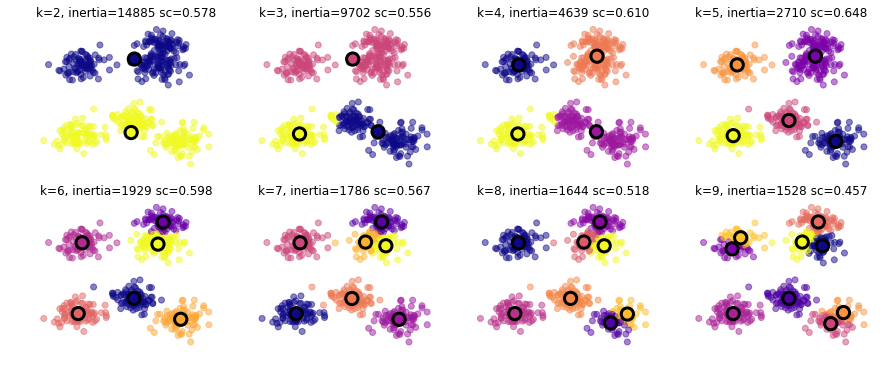

In [0]:
experiment_number_of_clusters(X, KMeans(), show_metric=True)

Ahora aplicamos la misma estrategia para el conjunto de datos de trilobites:

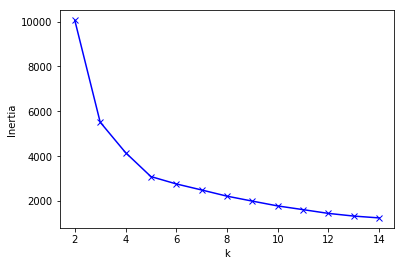

In [0]:
X = pd.read_csv("cluster1.csv").values
Sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

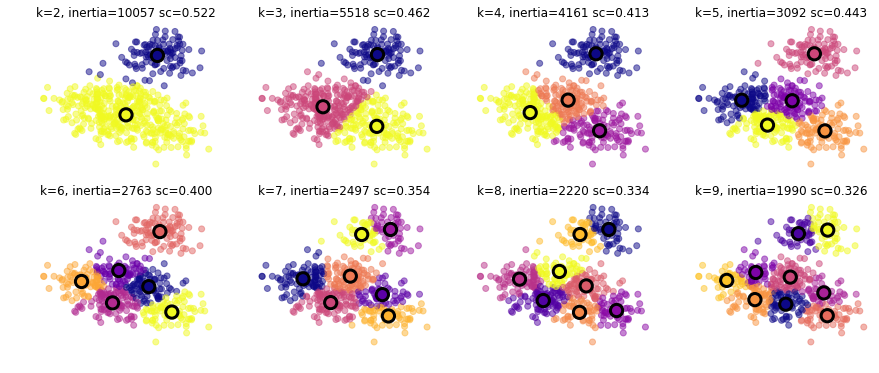

In [0]:
X = pd.read_csv("cluster1.csv").values
experiment_number_of_clusters(X, KMeans(), show_metric=True)


La gráfica de codo nos sugiere un valor de k=5 o k=6. La razón es que hay un cluster mucho más grande que el otro. Esto evidencia algunos de los problemas que tiene la inercia o suma de distancia intra-cluster:
*  La inercia supone que los clusters son convexos e isotrópicos, lo que no siempre es así. Responde mal a los grupos alargados, o múltiples con formas irregulares.
* La supone que los clusters son de tamaños similares, pues penaliza mucho más fuertemente clusters grandes.
* La inercia no es una métrica normalizada: solo sabemos que los valores más bajos son mejores y que el cero es óptimo.



### Coeficiente de silueta

El coeficiente de silueta combina la distancia media intra-cluster ($a$) y la distancia media al grupo más cercano ($b$) para cada muestra:
$$ \frac{b - a}{\max(a,b)}$$

Es una medida que está entre  -1 y 1. Un valor cercano a 1 indica que la distancia inter-cluster es mucho más grande que la distancia intra-cluster.

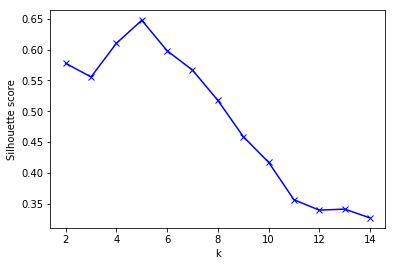

In [0]:
X,_ = make_blobs(500, cluster_std=1.5, centers=6, random_state=10)
silhouette_scores = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    y = km.predict(X)
    silhouette_scores.append(silhouette_score(X, y))
    
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()


En contraste con el diagrama de inercia donde buscamos el codo de la gráfica, aquí buscamos el valor máximo. Que en este caso es 5. Para el segundo conjunto de datos tenemos:

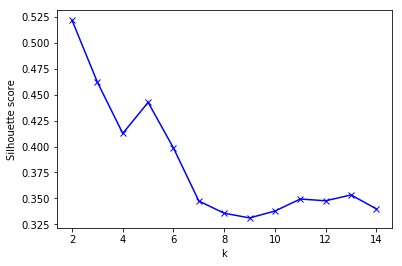

In [7]:
X = pd.read_csv("cluster1.csv").values
silhouette_scores = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    y = km.predict(X)
    silhouette_scores.append(silhouette_score(X, y))
    
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

### ¿Son _naturales_ los clusters generados por k-means para este conjunto de datos?



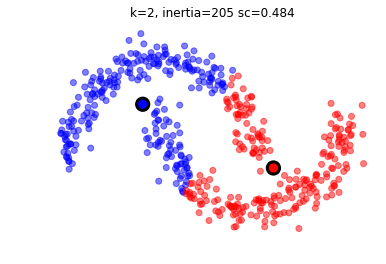

In [0]:
X,_ = make_moons(500, noise=.1)
plot_cluster_predictions(KMeans(), X, n_clusters=2,cmap=plt.cm.bwr, show_metric=True)

Cuando los clusters no son globulares, otros métodos pueden producir mejores resultados. 

## Métodos basados en densidad - DBSCAN

Es necesario especificar $\epsilon$ (radio máximo de una vecindad) y `min_samples`. No se especifica el número de clusters


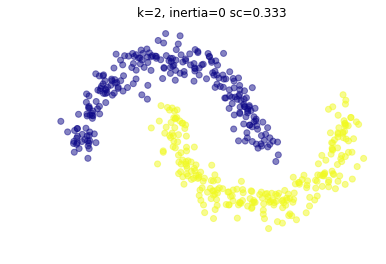

In [12]:
X,_ = make_moons(500, noise=.1)
dbs = DBSCAN(eps=.15, min_samples=4, metric='euclidean')
plot_cluster_predictions(dbs, X, cmap=plt.cm.plasma, show_metric=True)

DBSCAN es muy sensible a $\epsilon$:

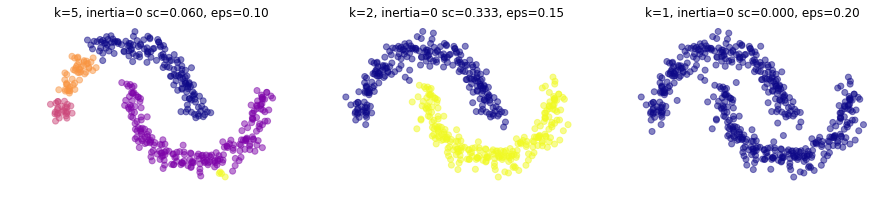

In [13]:
plt.figure(figsize=(15,3))
for i,eps in enumerate([.1,.15,.2]):
    plt.subplot(1,3,i+1)
    plot_cluster_predictions(DBSCAN(eps=eps, min_samples=4, metric='euclidean'), X, 
                                     cmap=plt.cm.plasma, show_metric=True, title_str=", eps=%.2f"%eps)


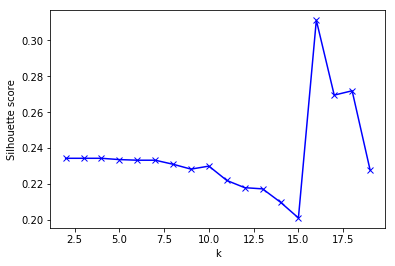

In [14]:
silhouette_scores = []
K = range(2,20)
for k in K:
    km = DBSCAN(eps=.15, min_samples=k, metric='euclidean')
    y = km.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, y))
    
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

In [18]:
silhouette_scores = []
K = range(2,20)
for k in K:
    km = DBSCAN(eps=.15, min_samples=k, metric='euclidean')
    y = km.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, y))
    
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

TypeError: ignored

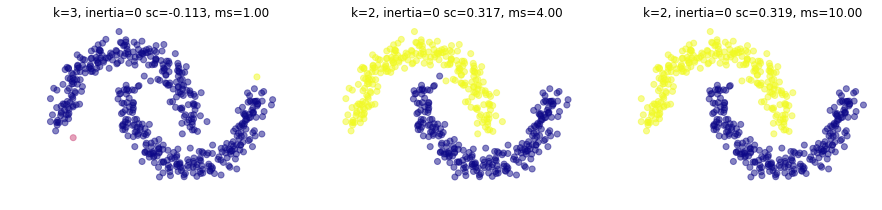

In [0]:
plt.figure(figsize=(15,3))
for i,min_samples in enumerate([1,4,10]):
    plt.subplot(1,3,i+1)
    plot_cluster_predictions(DBSCAN(eps=0.15, min_samples=min_samples, metric='euclidean'), X, 
                                     cmap=plt.cm.plasma, show_metric=True, title_str=", ms=%.2f"%min_samples)


## Métodos basados en conectividad - Agglomerative Clustering (Hierarchical)

Los métodos de agrupamiento basados en conectividad utilizan relaciones de vecindad entre los elementos para encontrar grupos. Estos métodos requieren construir una matrix de conectividad de los puntos. La función `kneighbors_graph` construye una matriz basada en los $k$ vecinos más cercanos de cada punto.

In [0]:
X,_ = make_moons(500, noise=.1)

(-0.8605497486721981, 1.3185536085386538)

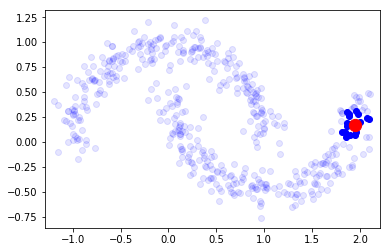

In [0]:
from sklearn.neighbors import kneighbors_graph
i = np.random.randint(len(X))
knn_graph = kneighbors_graph(X, 20, include_self=False)

nn = X[knn_graph[i].toarray()[0].astype(bool)]
plt.scatter(nn[:,0], nn[:,1], color="blue", alpha=1)
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.1)
plt.scatter(X[i,0], X[i,1], s=150, color="red")
plt.xlim(np.min(X[:,0])-.1, np.max(X[:,0])+.1)
plt.ylim(np.min(X[:,1])-.1, np.max(X[:,1])+.1)

usamos esta matriz de conectividad para suministrar información de estructura al algoritmo. En este caso vamos a usar un algoritmo de clustering aglomerativo, `AgglomerativeClustering`.

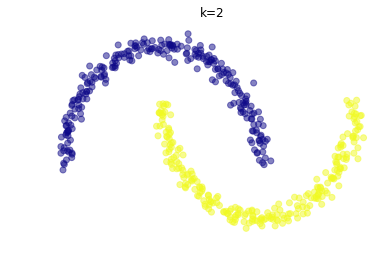

In [0]:
from sklearn.neighbors import kneighbors_graph
X,_ = make_moons(500, noise=.05)
knn_graph = kneighbors_graph(X, 20, include_self=False)
ac = AgglomerativeClustering(connectivity=knn_graph, linkage="average")

plot_cluster_predictions(ac, X, n_clusters=2, cmap=plt.cm.plasma)

Los grupos encontrados por el algoritmo depende del tamaño de la vecindad.

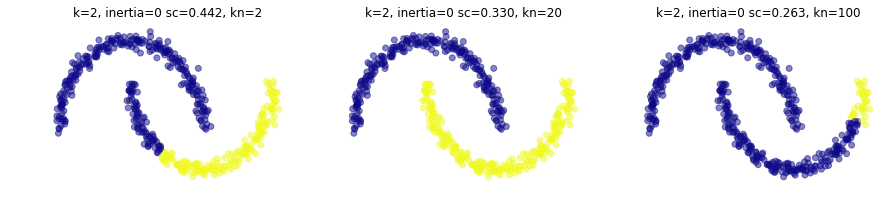

In [0]:
plt.figure(figsize=(15,3))
for i,kn in enumerate([2,20,100]):
    plt.subplot(1,3,i+1)
    knn_graph = kneighbors_graph(X, kn, include_self=False)
    plot_cluster_predictions(AgglomerativeClustering(connectivity=knn_graph, linkage="average"), X, 
                                     n_clusters=2, 
                                     cmap=plt.cm.plasma, show_metric=True, title_str=", kn=%d"%kn)

y del los distintos niveles de ruido en el dataset

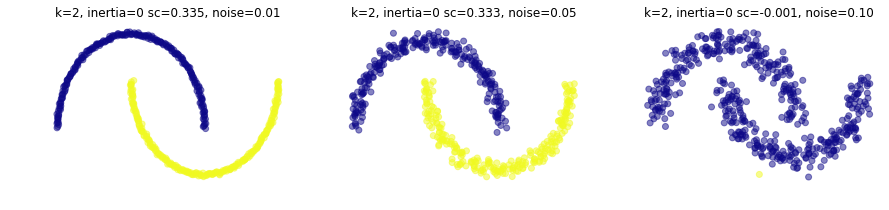

In [0]:
plt.figure(figsize=(15,3))
for i,noise in enumerate([.01,.05,.1]):
    plt.subplot(1,3,i+1)
    X,_ = make_moons(500, noise=noise)
    knn_graph = kneighbors_graph(X, 20, include_self=False)
    plot_cluster_predictions(AgglomerativeClustering(connectivity=knn_graph, linkage="average"), X, 
                                     n_clusters=2, 
                                     cmap=plt.cm.plasma, show_metric=True, title_str=", noise=%.2f"%noise)